In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn.model_selection import train_test_split

#tf.enable_eager_execution() #eager execution

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


I have predefined a matrix which acts as a mask denoting the areas which are photo-sensitive i.e. photodetectors. The "light" which falls onto these areas will be collected and summed.



In [ ]:
#loading the dataset.......(Detector)
detector = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/detector_template_28.txt",delimiter=' ')
print(detector.shape)
detector.head()

(11, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#loading the dataset.......(train,test)
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train.csv",delimiter=',',engine='c',na_filter=False,dtype=np.float32,low_memory=False)
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/test.csv",delimiter=',',engine='c',na_filter=False,dtype=np.float32,low_memory=False)

m,n = train.shape
mt,nt = test.shape
print(m,n)
train.head()

42000 785


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0.5, 1.0, 'Photodetector Layout')

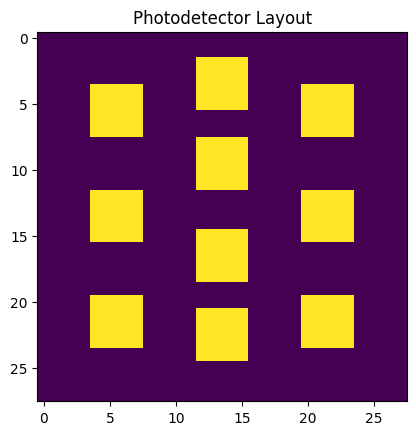

In [ ]:
x_train = (train.iloc[:,1:].values).astype('float32') # all pixel values
y_train = train.iloc[:,0].values.astype('int32') # only labels i.e targets digits

x_test = (test.iloc[:,:].values).astype('float32') # all pixel values

all_detectors = detector.iloc[0,:].values.astype('float32') # detector spatial layout
detector_template = detector.iloc[1:,].values.astype('float32') # individual detector positions

#Plot Detector layout
plt.figure()
plt.imshow(all_detectors.reshape((28,28)))
plt.title('Photodetector Layout')

In [ ]:
#Normalize the data and check data type
x_train = x_train/255.0
x_test = x_test/255.0
all_detectors = all_detectors.reshape((1,n-1))


In [ ]:
print('x_train shape:', x_train.shape)
print('x_train type:', x_train.dtype)
print('y_train shape:', y_train.shape)
print('y_train type:', y_train.dtype)
print('x_test shape:', x_test.shape)
print('x_test type:', x_test.dtype)
print('detector shape:', detector_template.shape)
print('detector type:', detector_template.dtype)
print('all detector shape:', all_detectors.shape)
print('all detector type:', all_detectors.dtype)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (42000, 784)
x_train type: float32
y_train shape: (42000,)
y_train type: int32
x_test shape: (28000, 784)
x_test type: float32
detector shape: (10, 784)
detector type: float32
all detector shape: (1, 784)
all detector type: float32
42000 train samples
28000 test samples


Since the distance between plates is the same for all the series of plates, I will pre-calculate the diffraction occuring at each plate and store the results as a numpy array to be used later.

In the journal paper, each plate has 200x200 nodes. Similarly, their input data should have 200x200 pixels. The kaggle dataset, as well as the original MNIST data, consists of images with 28x28 pixels. Hence, I have scaled down the physical system model in my simulation to fit the dataset from kaggle, using their setup as a guide.

For the diffraction, I follow the paper and use the Rayleigh-Sommerfeld equation.

In [ ]:
#Free-space propagation (diffraction)
#Plate size in paper is 8cm x 8cm

N = 28 #pixels per dimension
z = 1.05e-2 #3 cm between plates
weights = np.empty([N**2,N**2],dtype=complex)
lam = 299792458/0.4e12 #0.4 THz
print(1e3*lam) #in mm

D = N*(lam/2)
x1 = np.linspace(0,D,N)
y1 = np.linspace(0,D,N)

x2 = np.linspace(0,D,N)
y2 = np.linspace(0,D,N)

xg1,yg1,xg2,yg2 = np.meshgrid(x1,y1,x2,y2)

r = np.sqrt((xg1 - xg2)**2 + (yg1 - yg2)**2 + z**2)
dA = (D/N)**2 #differential area
w = (z/r**2) * (1/(2*np.pi*r) + 1/(1j*lam)) * np.exp(1j*2*np.pi*r/lam) * dA

weights = w.reshape(N**2,N**2)
print(weights.shape)

0.7494811450000001
(784, 784)


For verification, I plot the diffraction pattern that is output from a single node and arrives at the next printed plate.


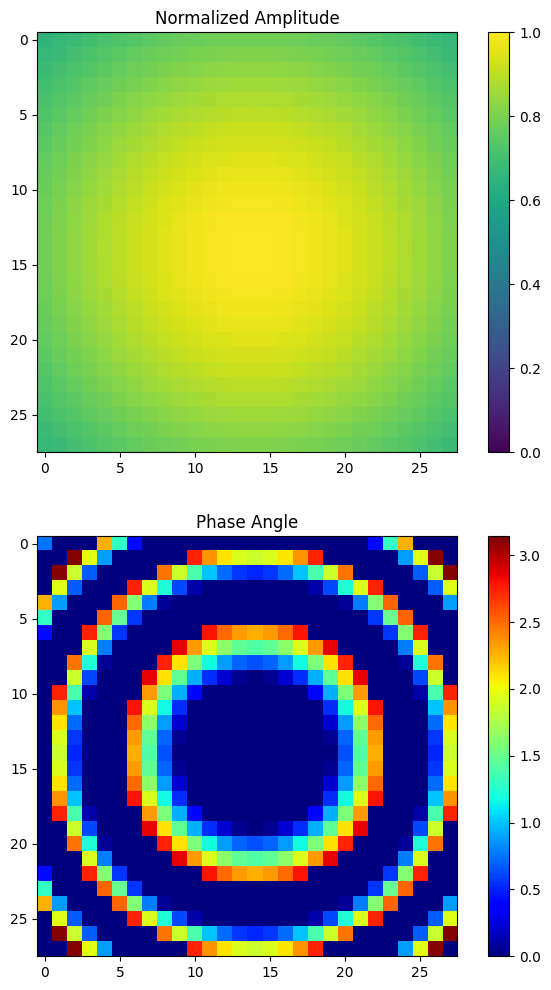

In [ ]:
#Plot Weight Function

plt.figure(figsize=(8,12))
we = weights[:,int(N*N/2+N/2)].reshape((N,N))

plt.subplot(2,1,1)
plt.imshow(np.abs(we)/np.max(np.abs(we)))
plt.colorbar()
plt.clim(0,1)
plt.title('Normalized Amplitude')

plt.subplot(2,1,2)
plt.imshow(np.angle(we),cmap='jet')
plt.colorbar()
plt.clim(0,math.pi)
plt.title('Phase Angle')

plt.show()

handwritten digit image after it passes through the 3D-printed plate and undergoes diffraction.



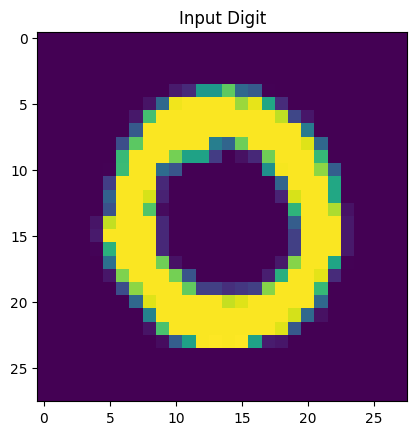

(784,)


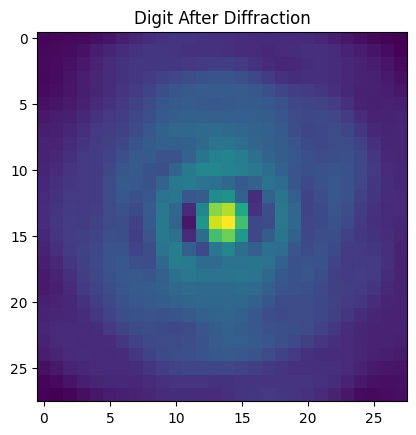

In [ ]:
#Visualize Diffraction
test_input = x_train[1,:]
plt.imshow(test_input.reshape((N,N)))
plt.title('Input Digit')
plt.show()

test_output = np.matmul(test_input,np.transpose(weights))
print(test_output.shape)
plt.imshow(np.abs(test_output.reshape((N,N),order='F')))
plt.title('Digit After Diffraction')
plt.show()

Now we have the dataset and the physical model ready. We can start the training of the Diffractive Network.


In [ ]:
#Training parameters
n_epochs = 50
batch_size = 10
n_batches = int(np.ceil(m / batch_size))
learning_rate = 0.001

In [ ]:
from tensorflow.python.framework import ops
ops.reset_default_graph()

import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()

#Construct Tensorflow Graph
inputs = tf.placeholder(tf.complex64, shape=(batch_size,N*N),name='inputs') #input test cases
labels = tf.placeholder(tf.int32, shape=(batch_size,),name='labels') #labels for test cases
w = tf.constant(weights, dtype=tf.complex64, name='w') #N**2 x N**2
d = tf.constant(detector_template, dtype=tf.float32, name='detectors') #10 x N**2
all_d = tf.constant(all_detectors, dtype=tf.float32, name='all_detectors') #1 x N**2

#Input layer
inputs1 = tf.matmul(inputs,tf.transpose(w))

def diffraction_layer(X):
    #Complex amplitude + phase of optical waves
    a = tf.Variable(tf.constant(1,shape=[1,N*N],dtype=tf.float32),name='alpha')
    t = tf.Variable(tf.constant(0.5,shape=[1,N*N],dtype=tf.float32),name='theta')
    pi = tf.constant(math.pi,dtype=tf.float32)
    theta = 2*pi*t #phase in exp(j*theta)
    phase_mod = tf.complex(tf.cos(theta),tf.sin(theta),name='phase_mod')
    a_mod = tf.nn.relu(a) / tf.reduce_max(tf.nn.relu(a))
    amp_mod = tf.cast(a_mod,dtype=tf.complex64,name='amp_mod')
    com_mod = tf.multiply(amp_mod,phase_mod,name='com_mod')

    layer = X * tf.tile(com_mod,[batch_size,1]) #BS x N**2
    return tf.matmul(layer,tf.transpose(w))

#Five 3D printed plates
outputs1 = diffraction_layer(inputs1)
outputs2 = diffraction_layer(outputs1)
outputs3 = diffraction_layer(outputs2)
outputs4 = diffraction_layer(outputs3)
outputsf = diffraction_layer(outputs4)

#Photodetectors
outputs_mask = tf.abs(outputsf) * tf.tile(all_d,[batch_size,1])

def normalize_output(A):
    m0,n0 = A.shape
    norm = tf.tile(tf.reshape(tf.reduce_max(A,axis=1),[m0,1]),[1,n0])
    norm_A = tf.square(A/norm)
    return norm_A

#Cross Entropy
out = tf.matmul(tf.abs(outputsf),tf.transpose(d)) #only sum over detectors
out_norm = normalize_output(out)
sm = tf.nn.softmax(logits=out_norm,name='soft_max')
xent = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels,logits=out_norm)
loss = tf.reduce_mean(xent,name='loss')

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
#Optimizer
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
#optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

training_op = optimizer.minimize(loss)

In [ ]:
#Mini-Batch Gradient Descent
def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)
    indices = np.random.randint(m, size=batch_size)
    X_batch = x_train[indices,]
    y_batch = y_train[indices,]
    return X_batch, y_batch

init = tf.global_variables_initializer()
saver = tf.train.Saver()

#Summary
loss_summary = tf.summary.scalar('Loss', loss)
file_writer = tf.summary.FileWriter("tf_logs", tf.get_default_graph())

#Session
with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        epoch_loss = 0 #reset loss
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)

            if batch_index % 100 == 0:
                summary_str = loss_summary.eval(feed_dict={inputs: X_batch, labels: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)

            _, batch_loss = sess.run([training_op,loss], feed_dict={inputs: X_batch, labels: y_batch})
            epoch_loss += batch_loss

        print("Epoch", epoch, "Loss =", epoch_loss/n_batches) #print out loss averaged over all batches
        save_path = saver.save(sess, "tmp/my_model.ckpt")

    save_path = saver.save(sess, "tmp/my_model_final.ckpt")

    #Sample Results From Mini-batch
    test_input = X_batch
    test_labels = y_batch
    test_softmax, test_output, test_mask, test_logits = sess.run([sm,outputsf,outputs_mask,out_norm],
                                                                   feed_dict={inputs: X_batch, labels: y_batch})

    #Complex Modulation
    c1, c2, c3, c4, c5 = sess.run([tf.get_default_graph().get_tensor_by_name("com_mod:0"),
                                   tf.get_default_graph().get_tensor_by_name("com_mod_1:0"),
                                   tf.get_default_graph().get_tensor_by_name("com_mod_2:0"),
                                   tf.get_default_graph().get_tensor_by_name("com_mod_3:0"),
                                   tf.get_default_graph().get_tensor_by_name("com_mod_4:0")])

file_writer.close()

Epoch 0 Loss = 1.6518451638448806
Epoch 1 Loss = 1.5960026428813026
Epoch 2 Loss = 1.5868652886152268
Epoch 3 Loss = 1.584364557748749
Epoch 4 Loss = 1.5818871991691135
Epoch 5 Loss = 1.579622633485567
Epoch 6 Loss = 1.5792866313173657
Epoch 7 Loss = 1.5790157997892016
Epoch 8 Loss = 1.5787620907454263
Epoch 9 Loss = 1.5771094607171559
Epoch 10 Loss = 1.5768106008711316
Epoch 11 Loss = 1.5760607416289194
Epoch 12 Loss = 1.5771286713509332
Epoch 13 Loss = 1.5762396793706077
Epoch 14 Loss = 1.5756836230130422
Epoch 15 Loss = 1.575634397552127
Epoch 16 Loss = 1.5760314317828132
Epoch 17 Loss = 1.5751505767163776
Epoch 18 Loss = 1.5756182949032103
Epoch 19 Loss = 1.574243616490137
Epoch 20 Loss = 1.5738763783659253
Epoch 21 Loss = 1.5738242275658108
Epoch 22 Loss = 1.5738792194638933
Epoch 23 Loss = 1.5725884950728644
Epoch 24 Loss = 1.5734544576349712
Epoch 25 Loss = 1.5731143720944722
Epoch 26 Loss = 1.5720893929402033
Epoch 27 Loss = 1.5742213061593828
Epoch 28 Loss = 1.5743824734858105

Let us visualize what the light pattern looks like on the the photodetector array. After propagation through the 3D plates, the light becomes focused onto certain spots corresponding to the "predicted" digit.

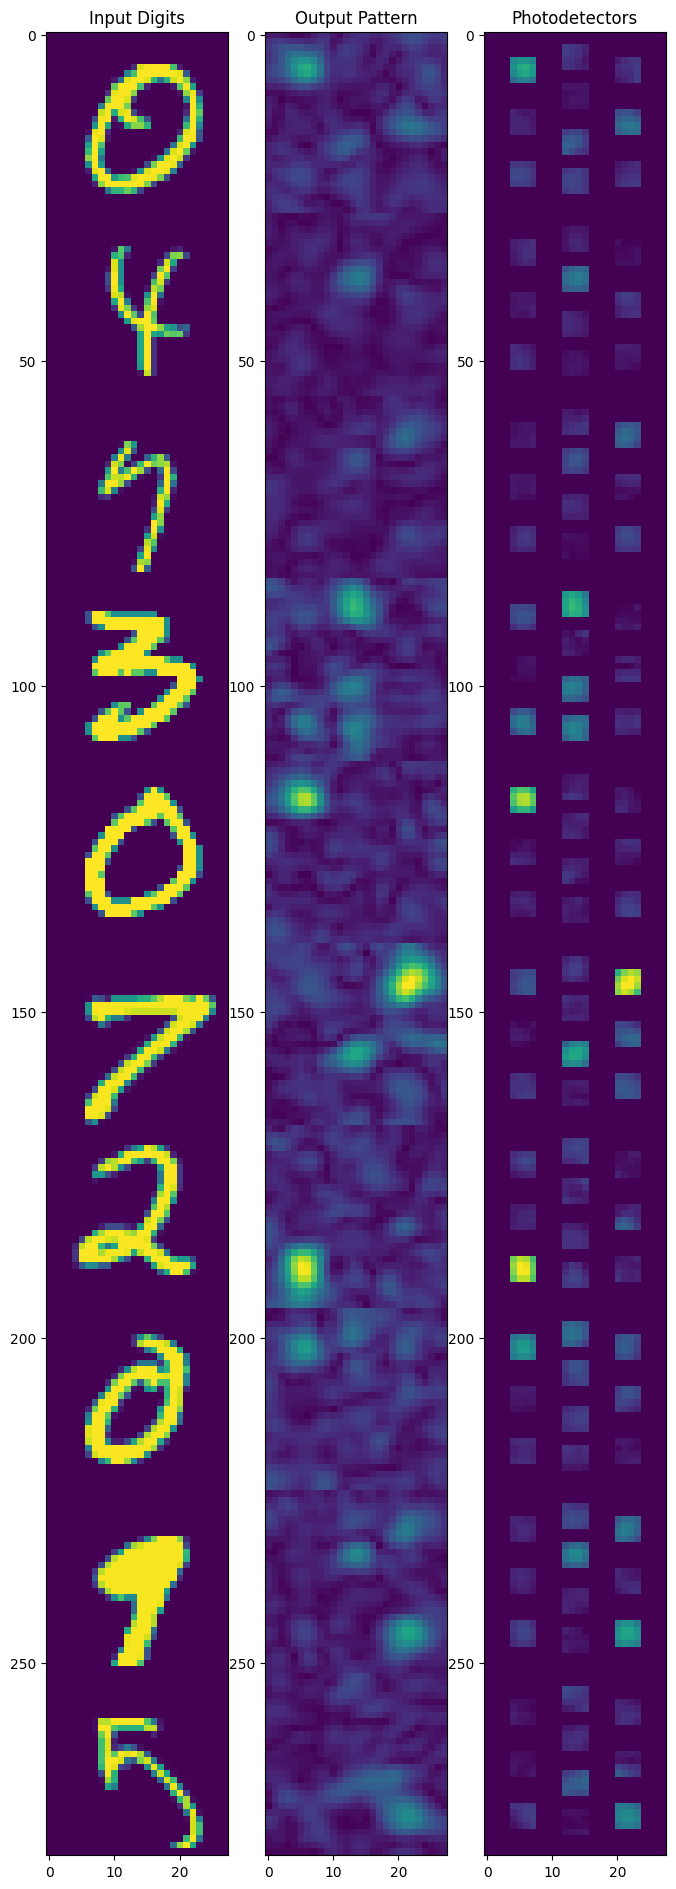

In [ ]:
plt.figure(figsize=((8,180)))
plt.subplot(1,3,1)
plt.imshow(np.abs(test_input).reshape((batch_size*N,N)))
plt.title('Input Digits')
plt.subplot(1,3,2)
plt.imshow(np.abs(test_output).reshape((batch_size*N,N)))
plt.title('Output Pattern')
plt.subplot(1,3,3)
plt.imshow(np.abs(test_mask).reshape((batch_size*N,N)))
plt.title('Photodetectors')
plt.show()

print(test_labels)
print(np.argmax(test_softmax,axis=1))

Let us the visualize the amplitude and phase modulation of the plate arrays.


[0 4 7 3 0 7 2 0 9 5]
[0 4 7 3 0 7 2 0 9 9]


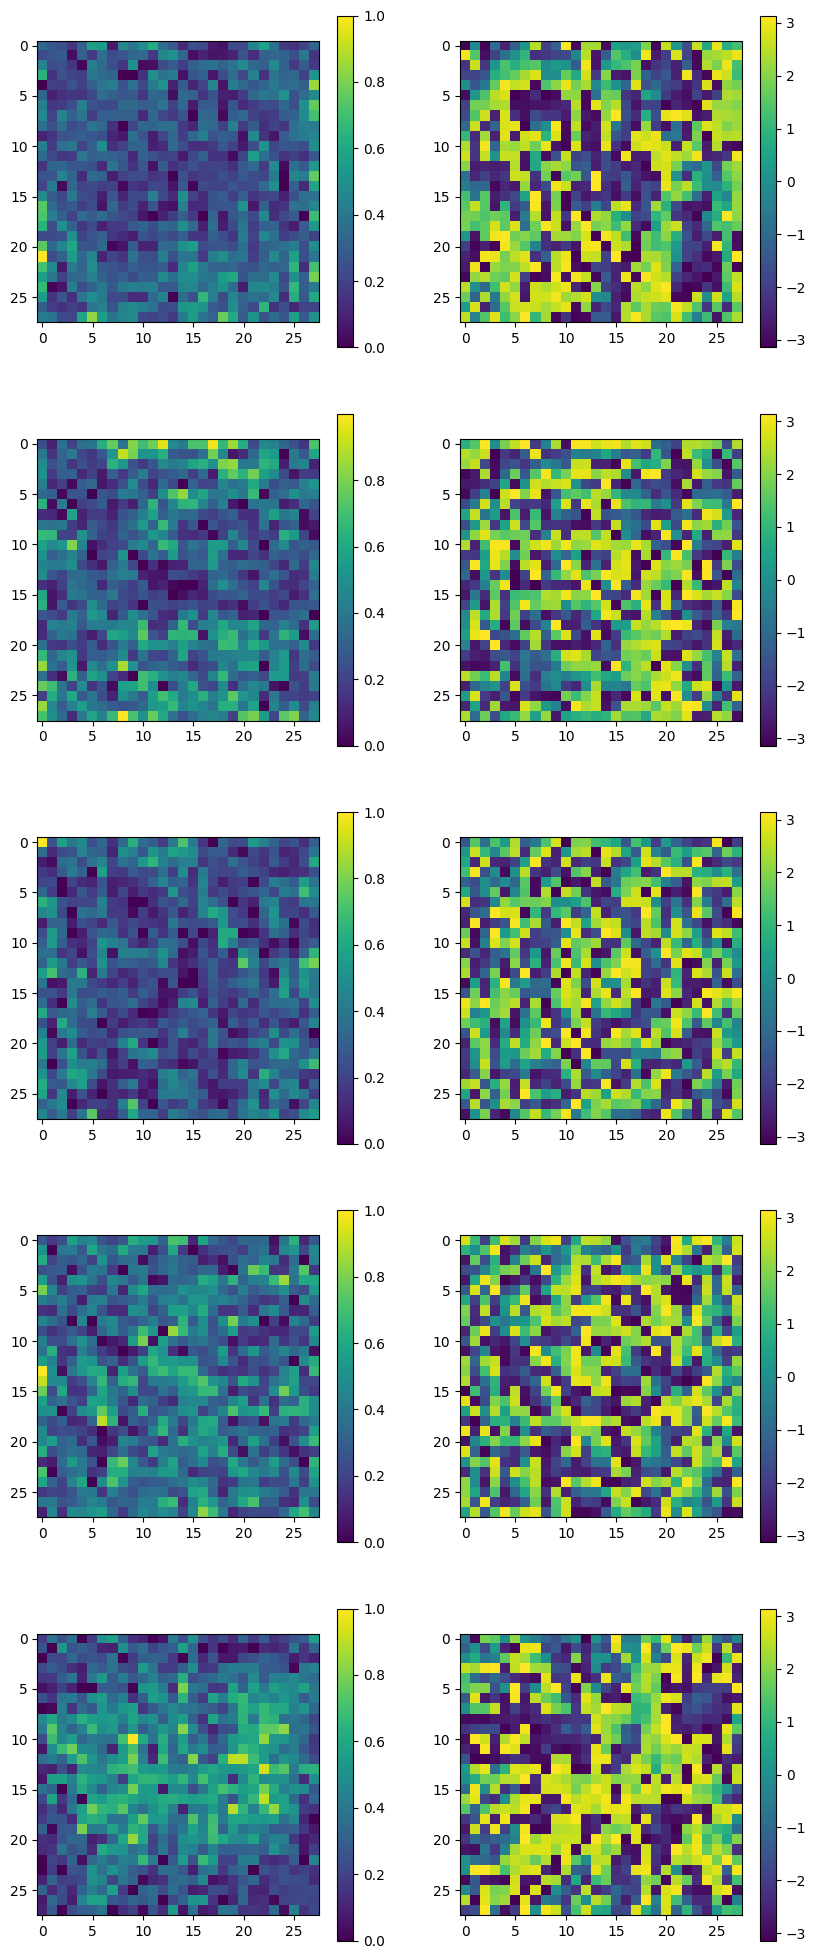

In [ ]:
def amp_phase(c):
    return np.abs(c),np.angle(c)

fig, ax = plt.subplots(5,2,figsize=((10,25)))

for ind,c in enumerate((c1,c2,c3,c4,c5)):
    A,P = amp_phase(c)
    im = ax[ind,0].imshow(A.reshape((N,N)))
    fig.colorbar(im,ax=ax[ind,0])
    im = ax[ind,1].imshow(P.reshape((N,N)))
    fig.colorbar(im,ax=ax[ind,1])


plt.show()

In [ ]:
#Predictions
test_softmax = np.empty((m,10))

with tf.Session() as sess:
    sess.run(init)
    saver.restore(sess, "tmp/my_model_final.ckpt")

    for batch_index in range(n_batches):
        start_ind = batch_index*batch_size
        end_ind = start_ind + batch_size
        test_softmax[start_ind:end_ind,:] = sm.eval(feed_dict={inputs: x_train[start_ind:end_ind,:]})

In [ ]:
#Naming Conventions
Y_pred = test_softmax
Y_pred_classes = np.argmax(Y_pred, axis = 1)
print(Y_pred_classes)
Y_true = y_train
X_val = x_train

[1 0 1 ... 7 6 9]


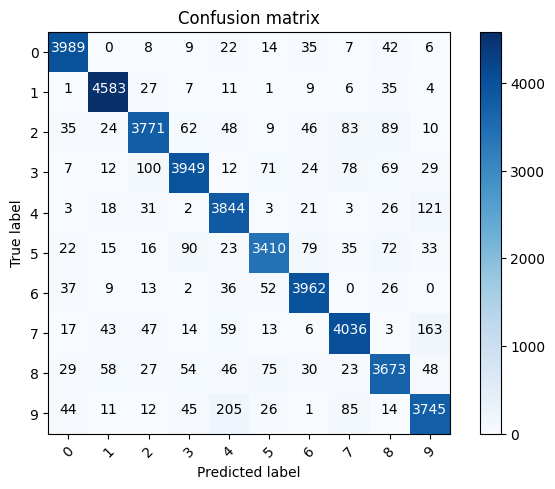

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

# Look at confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_train, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))
plt.show()

The errors are reasonable, but the achieved accuracy is bad not going to lie :(


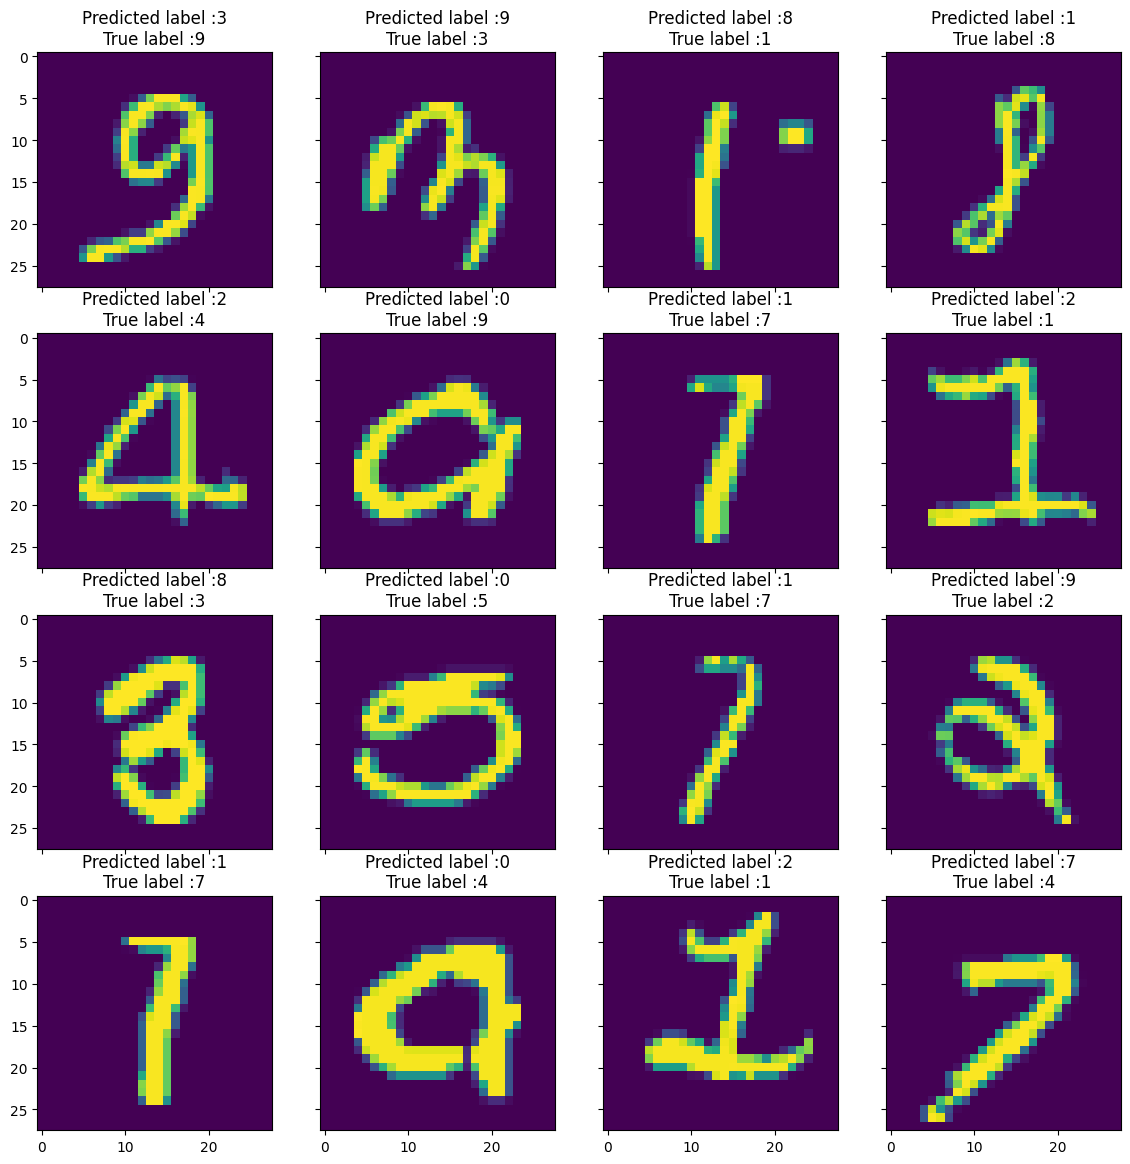

In [ ]:
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

top_x_error = 16

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows X images with their predicted and real labels"""
    n = 0
    nrows = int(np.sqrt(top_x_error))
    ncols = int(np.sqrt(top_x_error))
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=((14,14)))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((N,N)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top X errors
most_important_errors = sorted_dela_errors[-top_x_error:]

# Show the top X errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)
plt.show()

In [ ]:
acc = 1 - np.count_nonzero(errors)/m

print('Training Accuracy = {a:8.2f} %'.format(a=100*acc))

Training Accuracy =    92.77 %


In [ ]:
#Test parameters
n_batches = int(np.ceil(mt / batch_size))

test_softmax = np.empty((mt,10))

with tf.Session() as sess:
    sess.run(init)
    saver.restore(sess, "tmp/my_model_final.ckpt")

    for batch_index in range(n_batches):
        start_ind = batch_index*batch_size
        end_ind = start_ind + batch_size
        test_softmax[start_ind:end_ind,:] = sm.eval(feed_dict={inputs: x_test[start_ind:end_ind,:]})

In [ ]:
#Naming Conventions
Y_pred = test_softmax
Y_pred_classes = np.argmax(Y_pred, axis = 1)
print(Y_pred_classes)

[2 0 9 ... 3 9 2]


In [ ]:
results = pd.Series(Y_pred_classes,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("D2NN_submit.csv",index=False)